# Swin UNETR for multi-temporal Crack Detection

In [1]:
# Venv at: Studienarbeit/Model/SwinVE/bin/activate
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial
import wandb

import torch


from PIL import Image
from importlib import reload
from glob import glob
from natsort import natsorted
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader

import utils_UNETR
import dataset_UNETR
import augmentations_UNETR
import train_UNETR
import metrics_UNETR
import unet
import augmentations_exp3
reload(augmentations_exp3)
reload(utils_UNETR)
reload(dataset_UNETR)
reload(augmentations_UNETR)
reload(train_UNETR)
reload(metrics_UNETR)
from utils_UNETR import *
from dataset_UNETR import *
from augmentations_UNETR import *
from train_UNETR import *
from metrics_UNETR import *
from unet import *
from augmentations_exp3 import *


In [2]:
DATA_PATH = "../../data_creation/data_pipeline"

In [3]:
target_size = (128, 128, 32)
target_size_mono = (128, 128)
SEED = 42
n_classes = 1 # Probability for each pixel to be a crack
target_width=target_size[0]
target_height=target_size[1]

In [4]:
list_mt_images = glob(os.path.join(DATA_PATH, "multi-temporal_data_only_7-8", "mt-images", "*.npy"), recursive=True)
list_mt_images = natsorted(list_mt_images, key=lambda y: y.lower())

list_mt_targets = glob(os.path.join(DATA_PATH, "multi-temporal_data__only_7-8", "mt-targets", "*.npy"), recursive=True)
list_mt_targets = natsorted(list_mt_targets, key=lambda y: y.lower())

#### Extract dataset with 2/3 crack and 1/3 no crack images

In [5]:
df, _ = df_for_all_samples_mt(DATA_PATH, testset_size = 0.2, valset_size = 0.2, SEED = 42)
crack_images = df[df['crack'] != 0]

no_crack_images = df[df['crack'] == 0]

print(f"Ratio of crack images to no crack images in original dataset: {len(crack_images)/(len(crack_images)+len(no_crack_images))}.")

Ratio of crack images to no crack images in original dataset: 0.16051136363636365.


In [6]:
print(len(df))

5632


In [7]:
ratio = 2/3
num_total_images = int(len(crack_images)/ratio)
diff_no_crack_images = num_total_images - len(crack_images)
print(f"The crack images need to be extended by {diff_no_crack_images} no crack images to achieve a ratio of {round(100*ratio,2)}% crack images to no crack images.")

The crack images need to be extended by 452 no crack images to achieve a ratio of 66.67% crack images to no crack images.


In [8]:
selected_no_crack_images = no_crack_images.sample(n = diff_no_crack_images, random_state = SEED)

In [9]:
new_df = pd.concat([crack_images, selected_no_crack_images]).reset_index(drop=True)

#### Split for multi temporal new dataset

In [10]:

def analyz(df, target_size):
    sum_images_with_pixels = np.sum(df["crack"])
    print("Ratio of crack images to all images: " + str(round(100*sum_images_with_pixels/(len(df)),2)) + " %")
    sum_crack_pixels = np.sum(df["num_pixels"])
    print("Ratio of crack pixels to all pixels: " + str(round(100*sum_crack_pixels/(len(df)*target_size[0]*target_size[1]*target_size[2]),2)) + " %")
    print("Number of samples: {}\n".format(len(df)))

In [11]:
print("Multi-temporal Dataset \n")
train, val, test = create_splits(new_df, testset_size = 0.2, valset_size = 0.2, SEED = SEED, target_size = target_size)
analyz(new_df, target_size)
train_images = train["path_image"]
train_images = natsorted(train_images, key=lambda y: y.lower())
train_targets = train["path_target"]
train_targets = natsorted(train_targets, key=lambda y: y.lower())

val_images = val["path_image"]
val_images = natsorted(val_images, key=lambda y: y.lower())
val_targets = val["path_target"]
val_targets = natsorted(val_targets, key=lambda y: y.lower())

test_images = test["path_image"]
test_images = natsorted(test_images, key=lambda y: y.lower())
test_targets = test["path_target"]
test_targets = natsorted(test_targets, key=lambda y: y.lower())

Multi-temporal Dataset 

Training
Ratio of crack images to all images: 66.54 %
Ratio of crack pixels to all pixels: 1.25 %
Number of samples: 813

Validation
Ratio of crack images to all images: 66.79 %
Ratio of crack pixels to all pixels: 1.29 %
Number of samples: 271

Testing
Ratio of crack images to all images: 66.91 %
Ratio of crack pixels to all pixels: 1.21 %
Number of samples: 272

Ratio of crack images to all images: 66.67 %
Ratio of crack pixels to all pixels: 1.25 %
Number of samples: 1356



#### Split for monotemporal dataset

In [12]:
images_paths = os.path.join(DATA_PATH, "images_patches")
targets_paths = os.path.join(DATA_PATH, "targets_patches")

In [13]:
#mono_train_images, mono_train_targets = mono_temp_split_from_mt_split(images_paths, targets_paths, train_images, train_targets)
#mono_val_images, mono_val_targets = mono_temp_split_from_mt_split(images_paths, targets_paths, val_images, val_targets)
mono_test_images, mono_test_targets = mono_temp_split_from_mt_split(images_paths, targets_paths, test_images, test_targets)

In [14]:
#df_train = df_from_path_lists(mono_train_images, mono_train_targets)
#df_val = df_from_path_lists(mono_val_images, mono_val_targets)
df_test = df_from_path_lists(mono_test_images, mono_test_targets)

In [15]:
df_combined = pd.concat([df_train, df_val, df_test], axis=0)
df_combined = df_combined.reset_index(drop=True)
total_pixels = df_combined["num_pixels"].sum()
print(total_pixels/(43392*128*128))

NameError: name 'df_train' is not defined

In [20]:
print("Mono-temporal Dataset\n")
#print("Training")
#analyse_df_mono(df_train, target_size_mono)
#print("\nValdiation")
#analyse_df_mono(df_val, target_size_mono)
print("\nTesting")
analyse_df_mono(df_test, target_size)

Mono-temporal Dataset


Testing
Ratio of crack images to all images: 41.2914 %
Ratio of crack pixels to all pixels: 1.2067 %
Number of samples: 8704



#### Experiment 1 - Skip monotemporal split

Use the same number of samples for the UNet as in the SwinUNetR.

In [12]:
sample_size_train = len(train_images)
sample_size_val = len(val_images)
sample_size_test = len(test_images)

In [13]:
images_paths = os.path.join(DATA_PATH, "images_patches")
targets_paths = os.path.join(DATA_PATH, "targets_patches")
list_images_78, list_targets_78 = get_only_78_mono_images_from_all_images(images_paths, targets_paths)

In [14]:
print(len(list_images_78))

180224


In [15]:
def get_mono_from_mt(mt_images, mono_images, mono_targets):
    mt_coordinates_set = set()
    for mt_image_path in mt_images:
        file_name = os.path.basename(mt_image_path)
        file_name, ext = os.path.splitext(file_name)
        coordinates = file_name.split("_")[-2:]
        coordinates = "_".join(coordinates)
        mt_coordinates_set.add(coordinates)
    mono_images_wrt_mt_images = []
    mono_targets_wrt_mt_images = []
    for mono_image_path, mono_target_path in zip(mono_images, mono_targets):
        file_name = os.path.basename(mono_image_path)
        file_name, ext = os.path.splitext(file_name)
        coordinates = file_name.split("-")[-1]
        if coordinates in mt_coordinates_set:
            mono_images_wrt_mt_images.append(mono_image_path)
            mono_targets_wrt_mt_images.append(mono_target_path)
    return mono_images_wrt_mt_images, mono_targets_wrt_mt_images

In [16]:

def df_from_path_lists(list_images,list_targets):
    pixel_count = []
    for target_path in list_targets:
        target = Image.open(target_path)
        target = np.array(target)
        num_crack_pxls = np.sum(target)
        pixel_count.append(num_crack_pxls)
    contains_cracks = [0 if x == 0 else 1 for x in pixel_count]

    df = pd.DataFrame(zip(list_images, list_targets, contains_cracks, pixel_count),
                        columns = ["path_image", "path_target","crack", "num_pixels"])
    return df

In [17]:
mono_train_images, mono_train_targets = get_mono_from_mt(train_images, list_images_78, list_targets_78)
df_train = df_from_path_lists(mono_train_images, mono_train_targets)
mono_val_images, mono_val_targets = get_mono_from_mt(val_images, list_images_78, list_targets_78)
df_val = df_from_path_lists(mono_val_images, mono_val_targets)
mono_test_images, mono_test_targets = get_mono_from_mt(test_images, list_images_78, list_targets_78)
df_test = df_from_path_lists(mono_test_images, mono_test_targets)

In [18]:
df_test

path_image  \
0     ../../data_creation/data_pipeline/images_patch...   
1     ../../data_creation/data_pipeline/images_patch...   
2     ../../data_creation/data_pipeline/images_patch...   
3     ../../data_creation/data_pipeline/images_patch...   
4     ../../data_creation/data_pipeline/images_patch...   
...                                                 ...   
8699  ../../data_creation/data_pipeline/images_patch...   
8700  ../../data_creation/data_pipeline/images_patch...   
8701  ../../data_creation/data_pipeline/images_patch...   
8702  ../../data_creation/data_pipeline/images_patch...   
8703  ../../data_creation/data_pipeline/images_patch...   

                                            path_target  crack  num_pixels  
0     ../../data_creation/data_pipeline/targets_patc...      0           0  
1     ../../data_creation/data_pipeline/targets_patc...      0           0  
2     ../../data_creation/data_pipeline/targets_patc...      0           0  
3     ../../data_creation/data_pipeline/targets_patc...      0           0  
4     ../../data_creation/data_pipeline/targets_patc...      0           0  
...                                                 ...    ...         ...  
8699  ../../data_creation/data_pipeline/targets_patc...      0           0  
8700  ../../data_creation/data_pipeline/targets_patc...      0           0  
8701  ../../data_creation/data_pipeline/targets_patc...      0           0  
8702  ../../data_creation/data_pipeline/targets_patc...      0           0  
8703  ../../data_creation/data_pipeline/targets_patc...      0           0  

[8704 rows x 4 columns]

In [149]:
def experiment1(df, size, ratio, SEED):
    crack_images = df[df['crack'] != 0]
    print(len(crack_images))
    no_crack_images = df[df['crack'] == 0]

    num_crack_images = int(ratio * size)
    print(num_crack_images)
    
    num_no_crack_images = int(size - num_crack_images)

    
    crack_images = crack_images.sample(n = num_crack_images, random_state = SEED)
    no_crack_images = no_crack_images.sample(n = num_no_crack_images, random_state = SEED)
    
    df_new = pd.concat([crack_images, no_crack_images]).reset_index(drop=True)
    return df_new


In [150]:
train = experiment1(df_train, sample_size_train, 2/3, SEED)
val = experiment1(df_val, sample_size_val, 2/3, SEED)
test = experiment1(df_test, sample_size_test, 2/3, SEED)

10427
542
3387
180
3594
181


In [153]:
analyse_df_mono(train, target_size_mono)
analyse_df_mono(val, target_size_mono)
analyse_df_mono(test, target_size_mono)

Ratio of crack images to all images: 66.67 %
Ratio of crack pixels to all pixels: 1.94 %
Number of samples: 813

Ratio of crack images to all images: 66.42 %
Ratio of crack pixels to all pixels: 2.02 %
Number of samples: 271

Ratio of crack images to all images: 66.54 %
Ratio of crack pixels to all pixels: 1.7 %
Number of samples: 272



In [106]:
train_images = train["path_image"]
train_images = natsorted(train_images, key=lambda y: y.lower())
train_targets = train["path_target"]
train_targets = natsorted(train_targets, key=lambda y: y.lower())

val_images = val["path_image"]
val_images = natsorted(val_images, key=lambda y: y.lower())
val_targets = val["path_target"]
val_targets = natsorted(val_targets, key=lambda y: y.lower())

#### Experiment 2

In [21]:
import utils_UNETR
import dataset_UNETR
import augmentations_UNETR
import train_UNETR
import metrics_UNETR
import unet
reload(utils_UNETR)
reload(dataset_UNETR)
reload(augmentations_UNETR)
reload(train_UNETR)
reload(metrics_UNETR)
from utils_UNETR import *
from dataset_UNETR import *
from augmentations_UNETR import *
from train_UNETR import *
from metrics_UNETR import *
from unet import *

In [22]:
trans = transforms.Compose([
    RandomContrast_mt(p = 0.5, contrast_range = (0.1,1.9)),
    RandomVerticalFlip_mt(p=0.5),
    RandomHorizontalFlip_mt(p=0.5),
    RandomBlur_mt(p = 0.5, sigma_range = (0.5, 2.0)),
    RandomBrightness_mt(p=0.5, brightness_range=(0.5, 1.7)),
    ToTensor_mt()])

In [130]:
train_mt_dataset = MtCrackDataset(train_images, train_targets, transform = trans)
val_mt_dataset = MtCrackDataset(val_images, val_targets)

Compose(
)


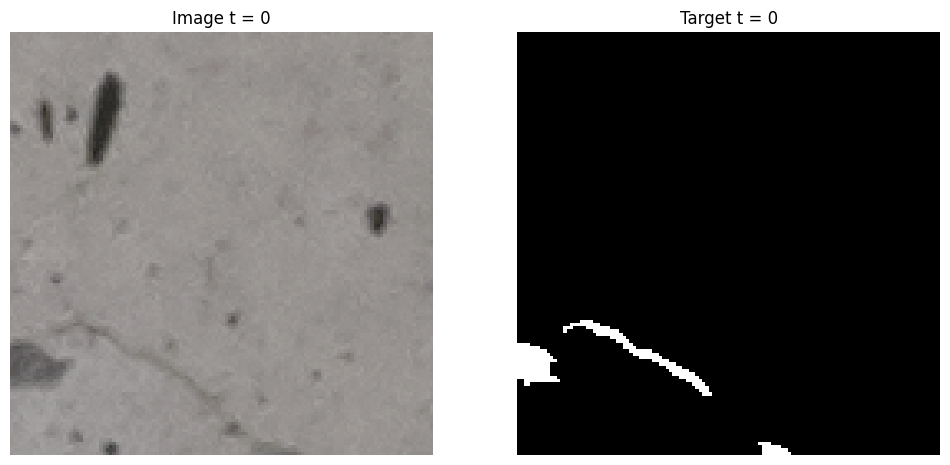

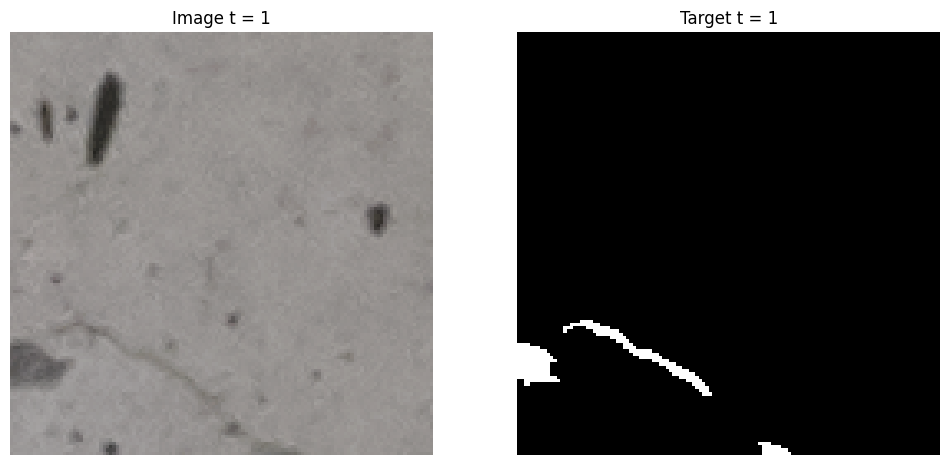

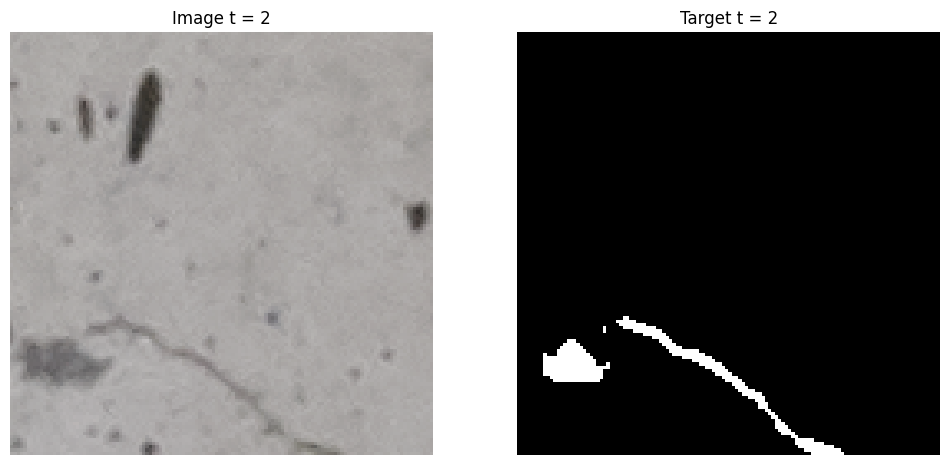

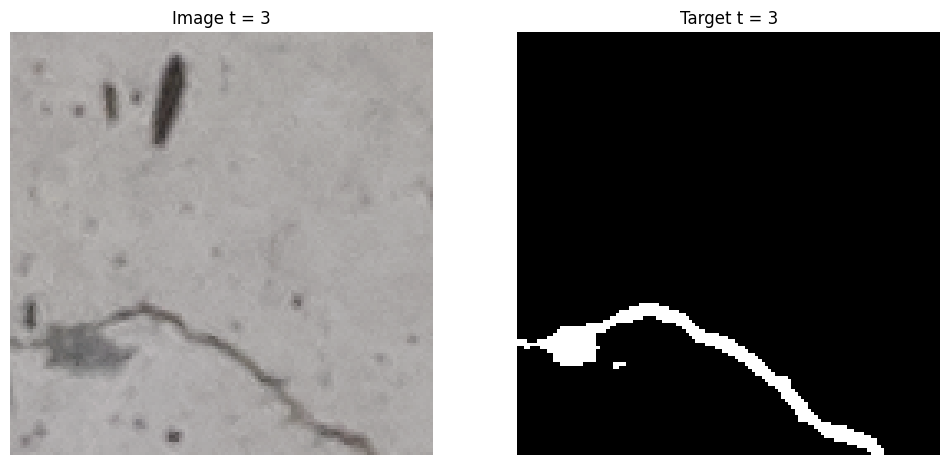

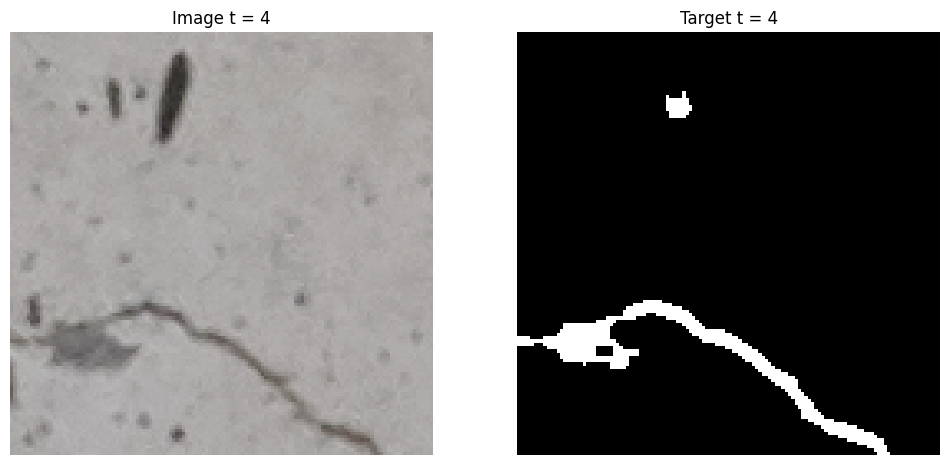

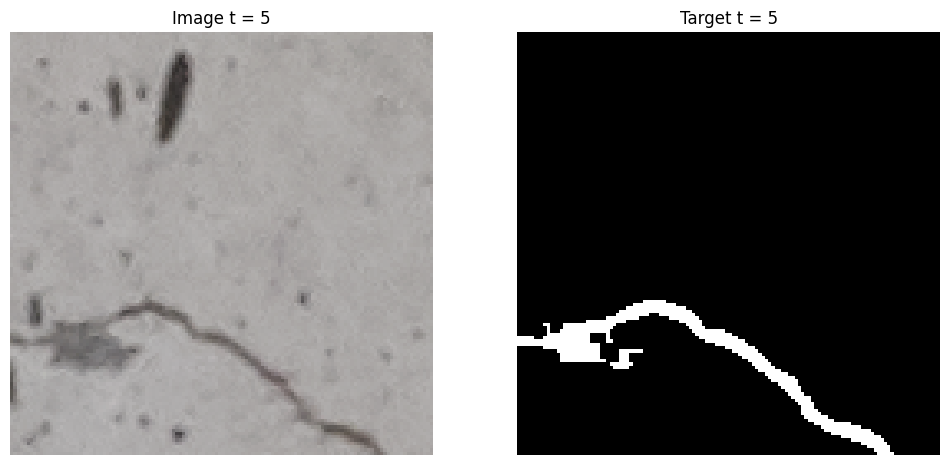

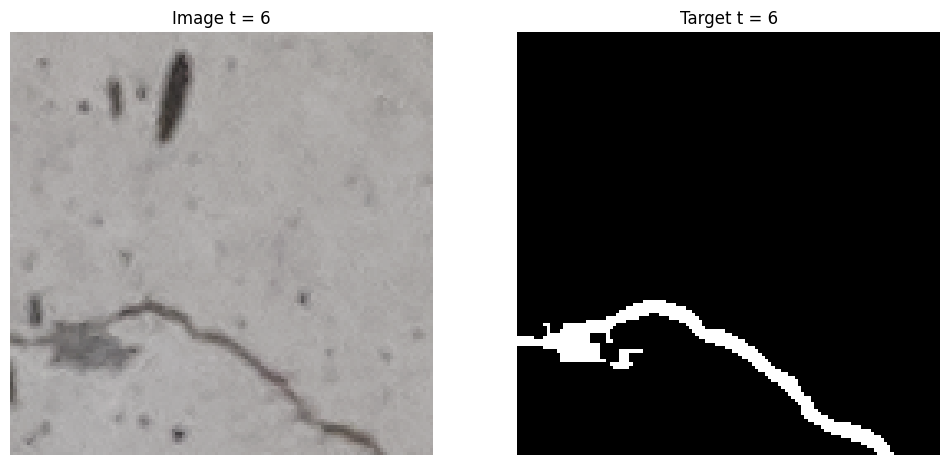

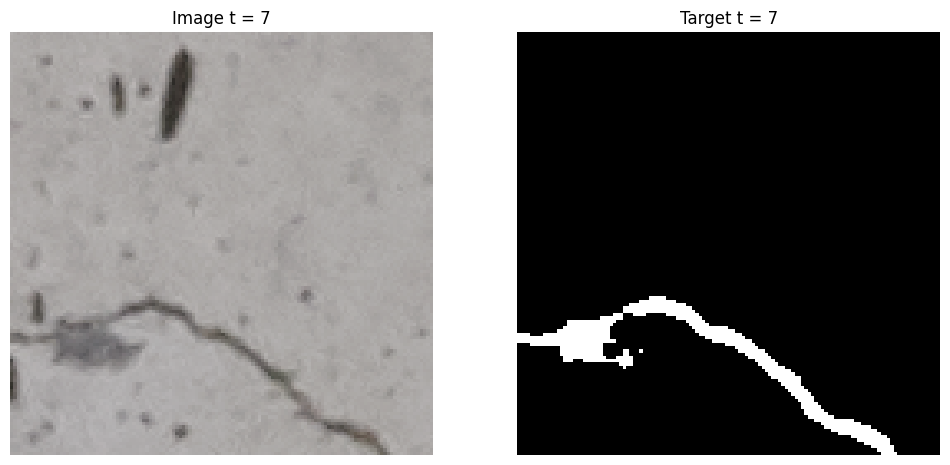

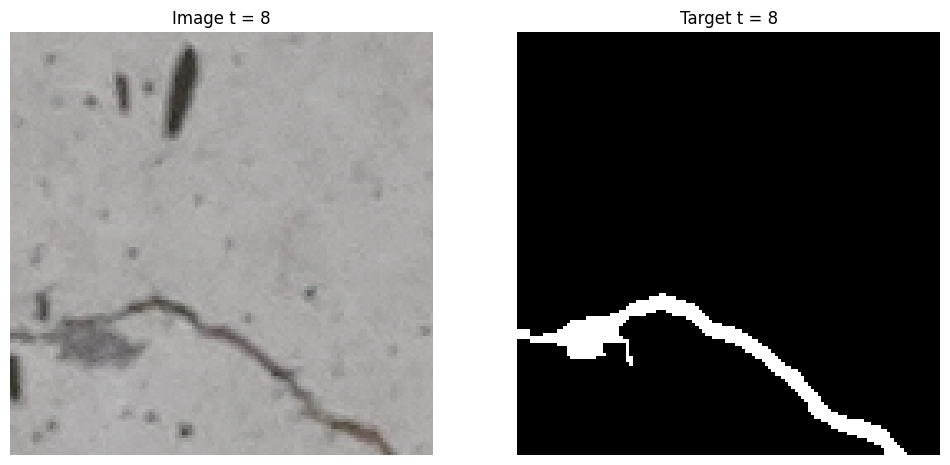

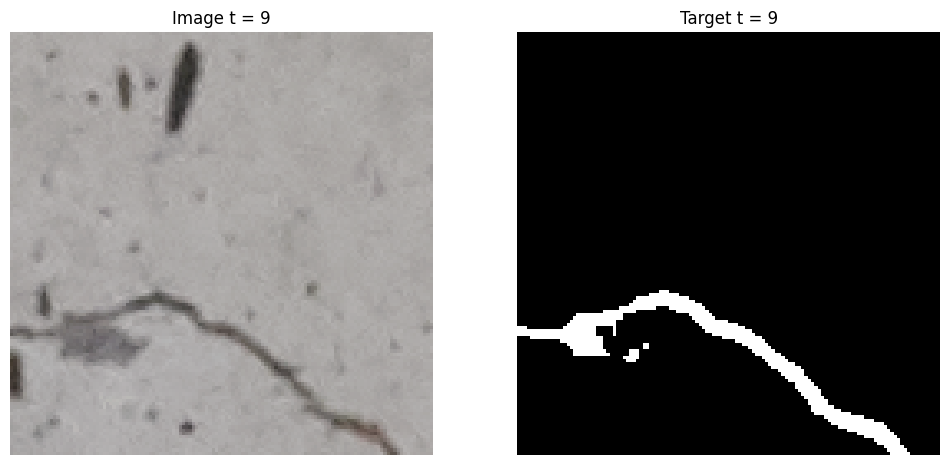

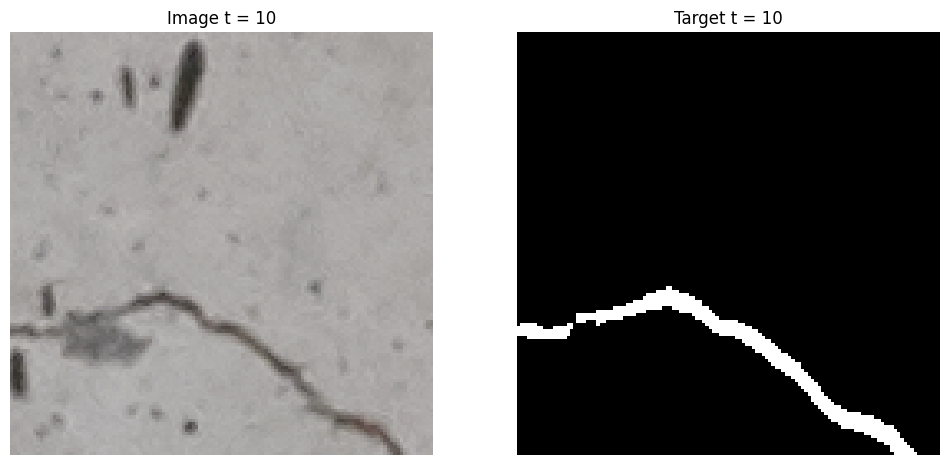

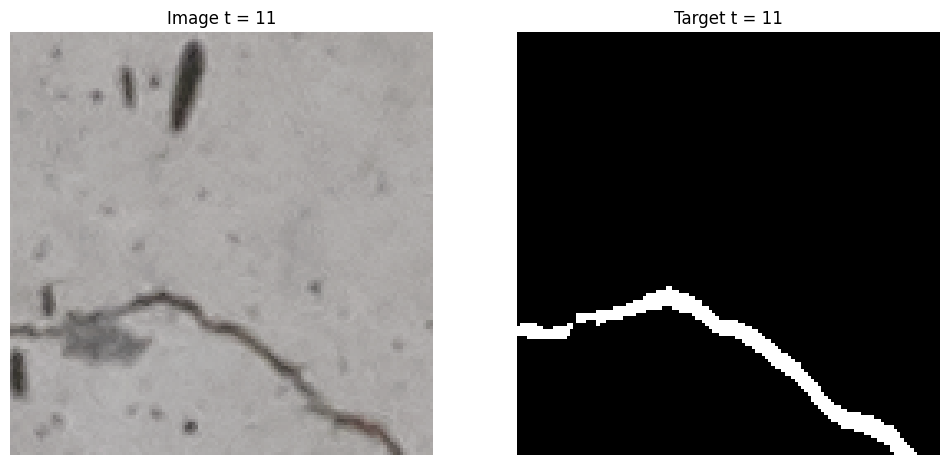

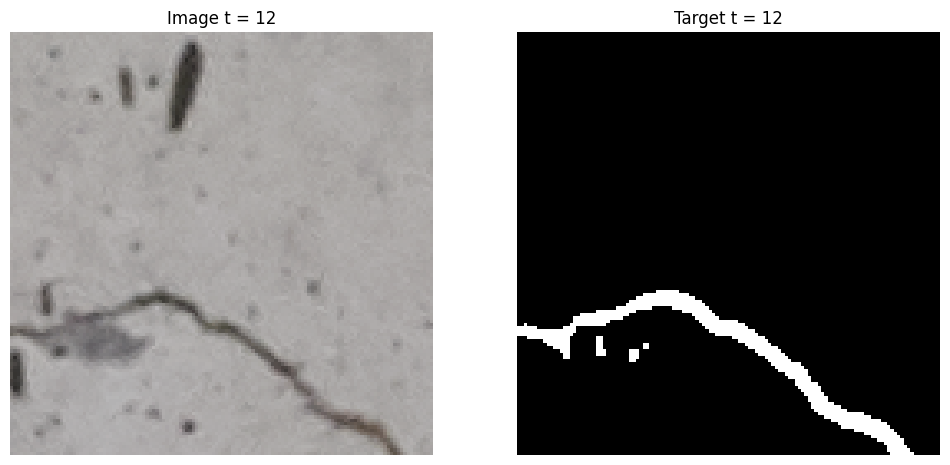

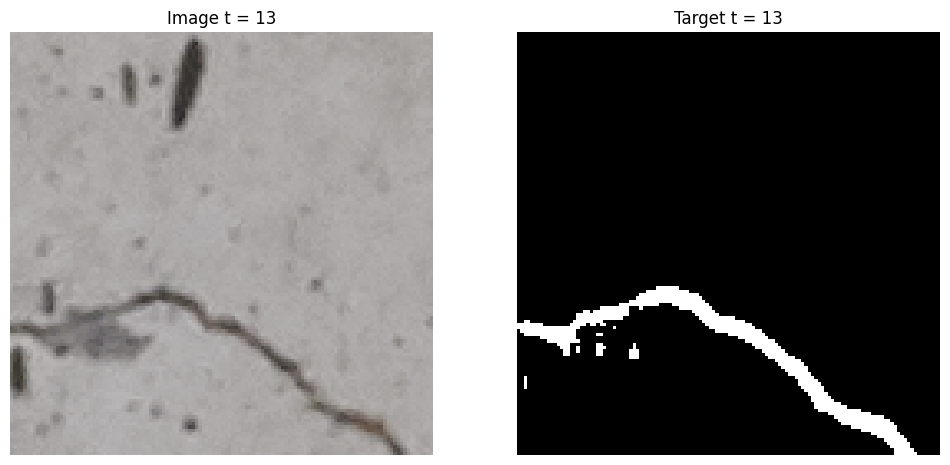

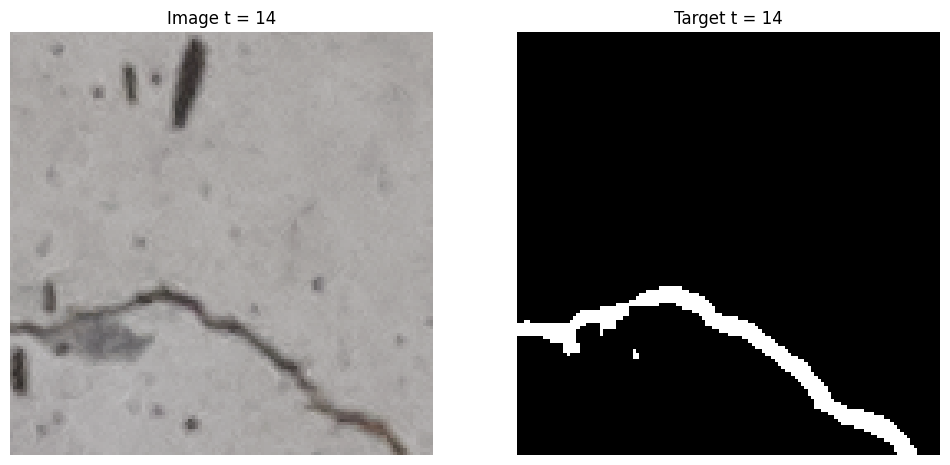

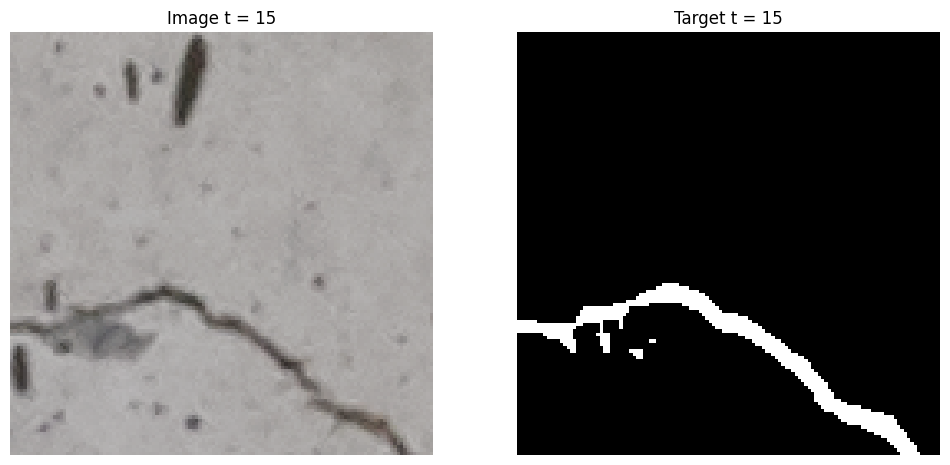

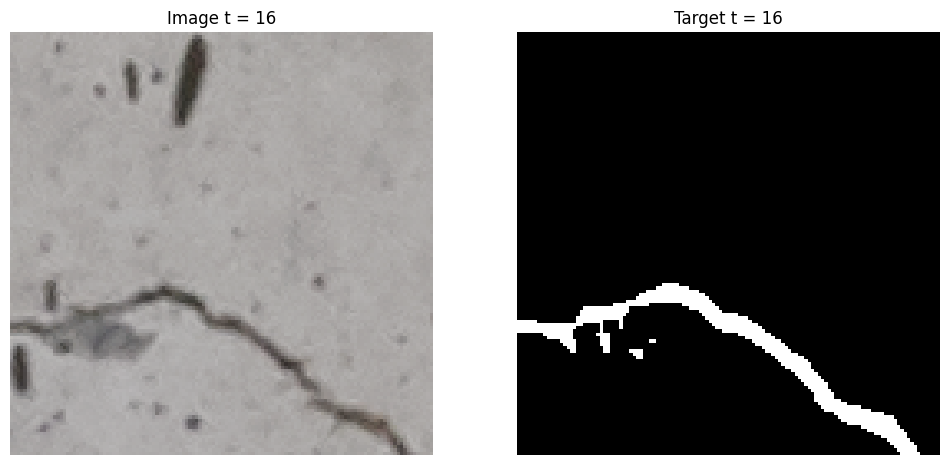

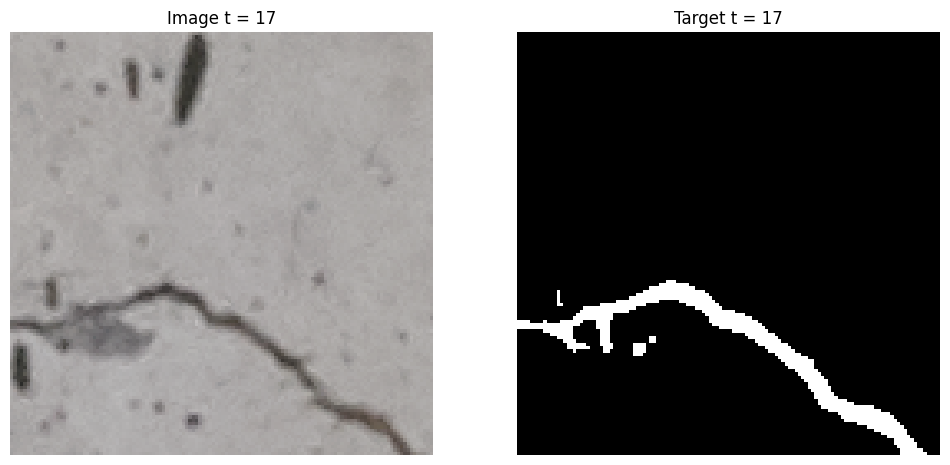

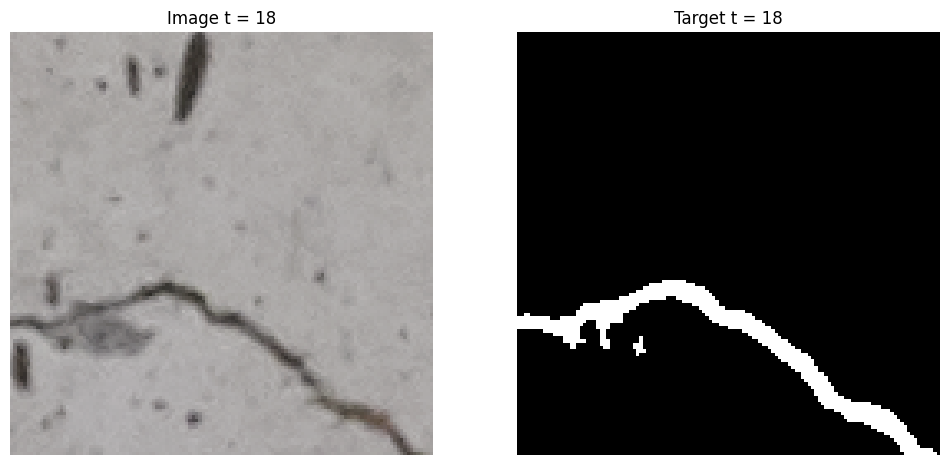

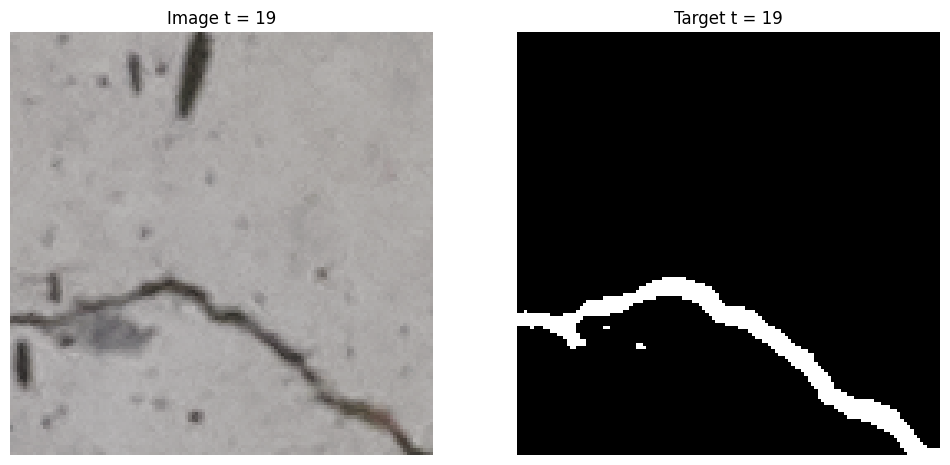

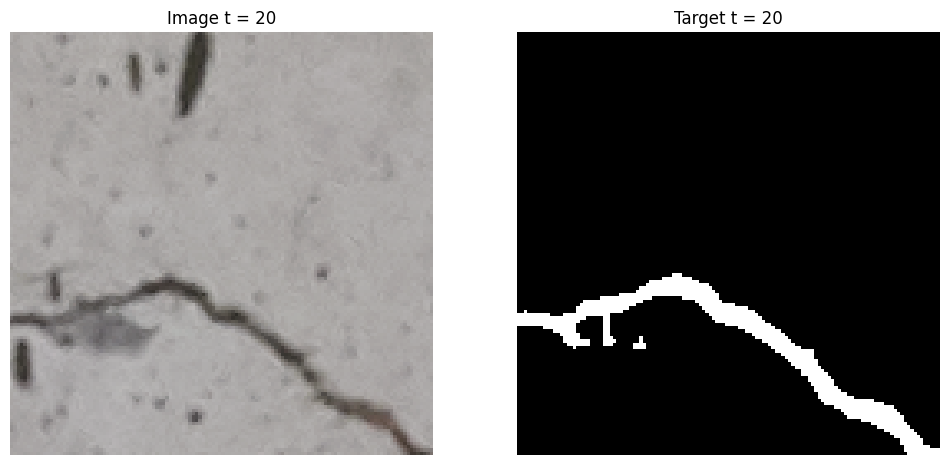

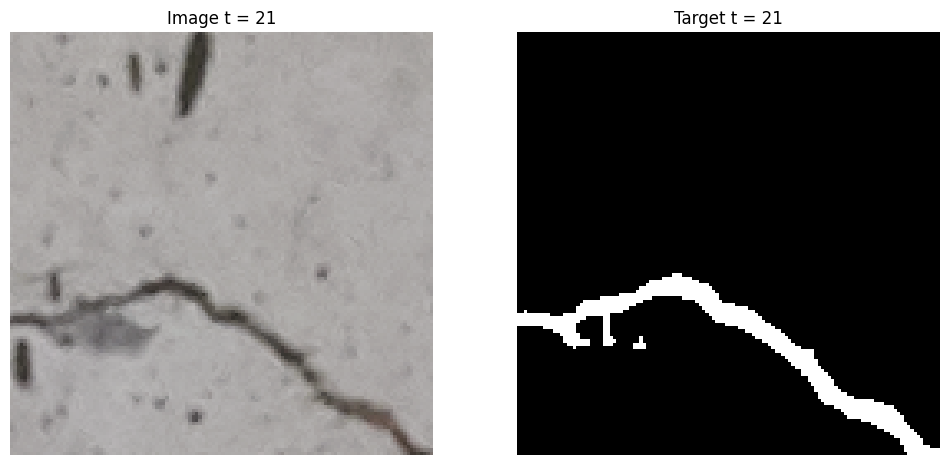

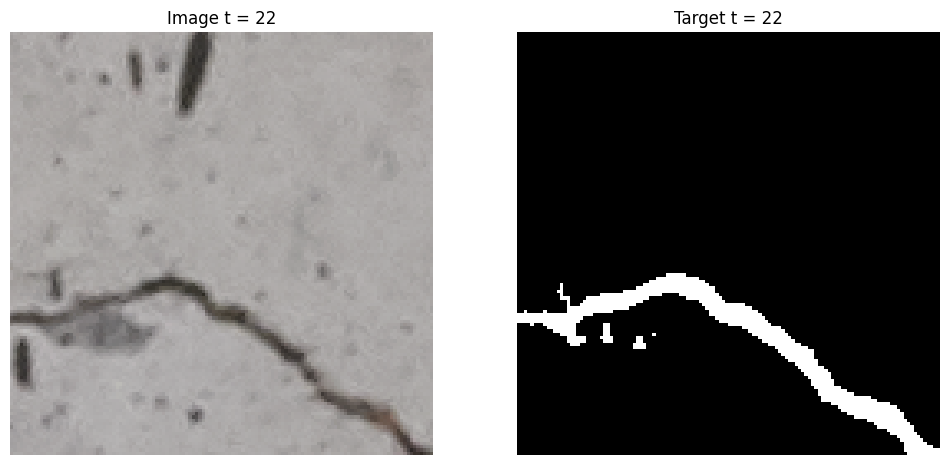

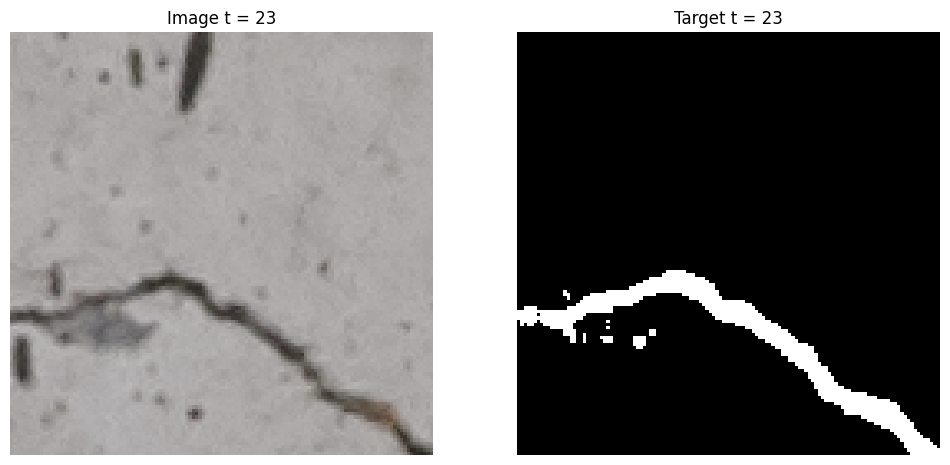

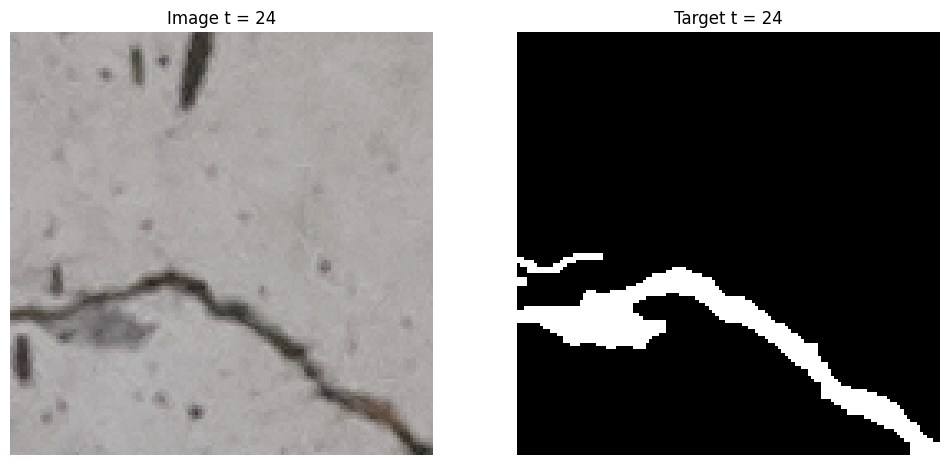

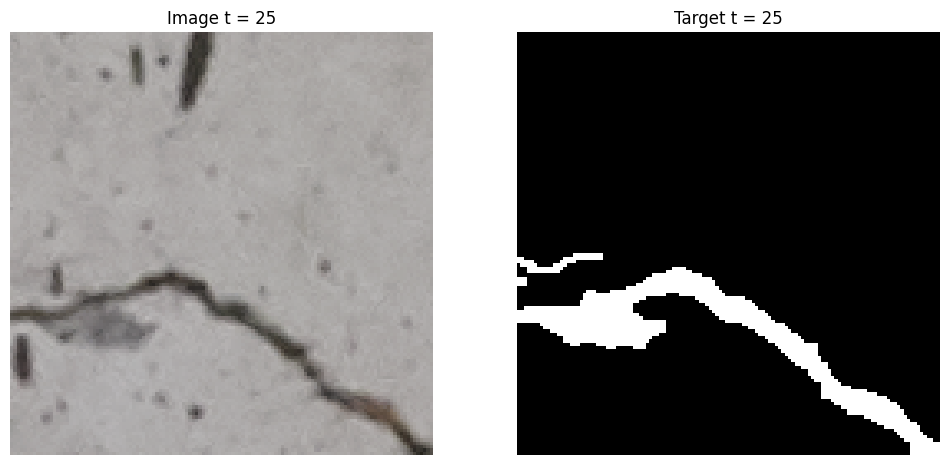

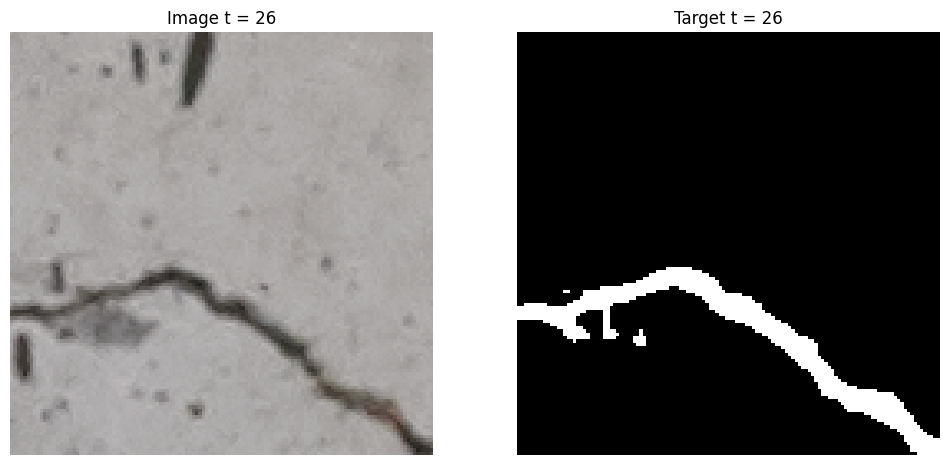

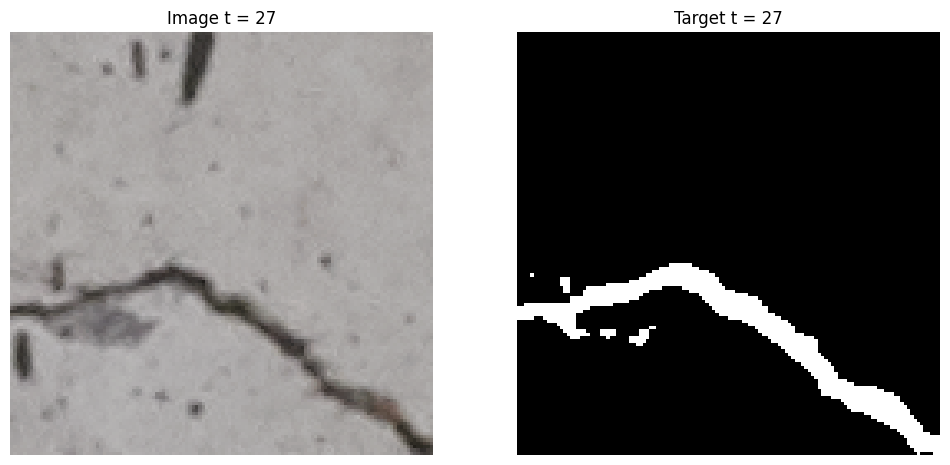

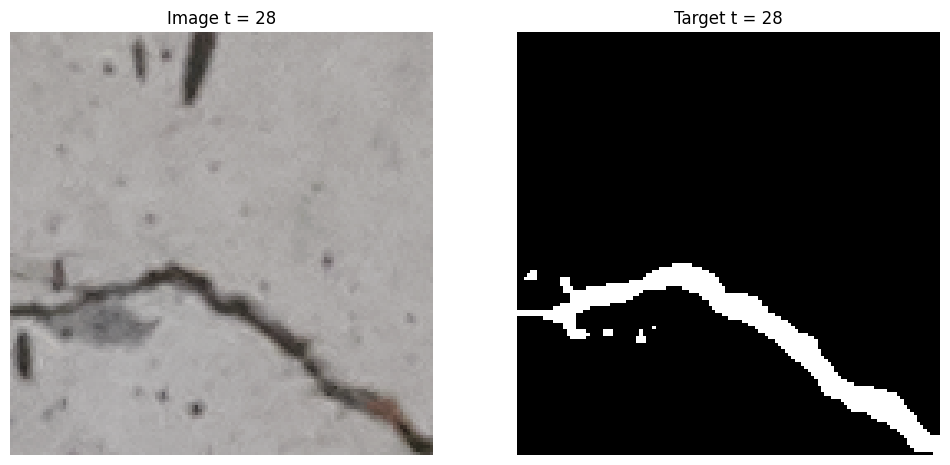

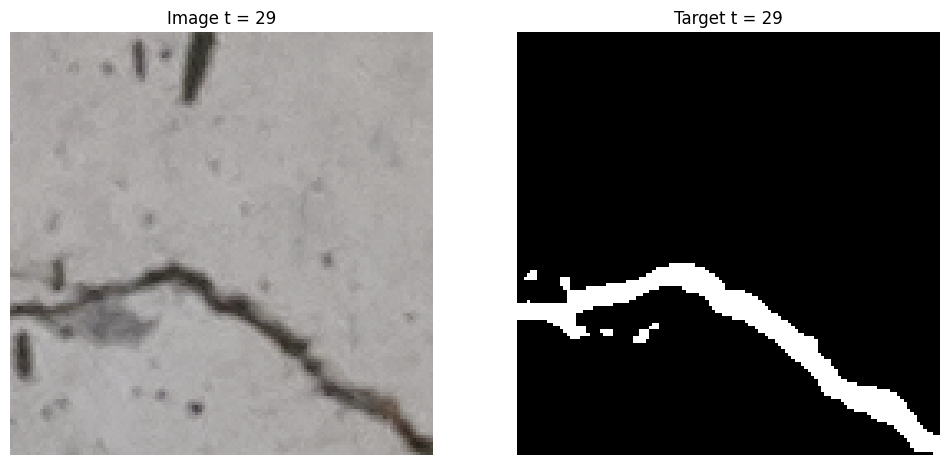

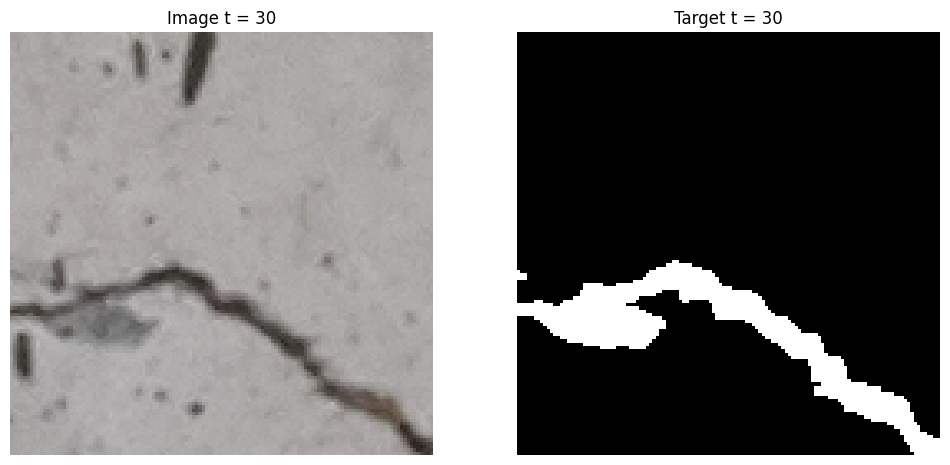

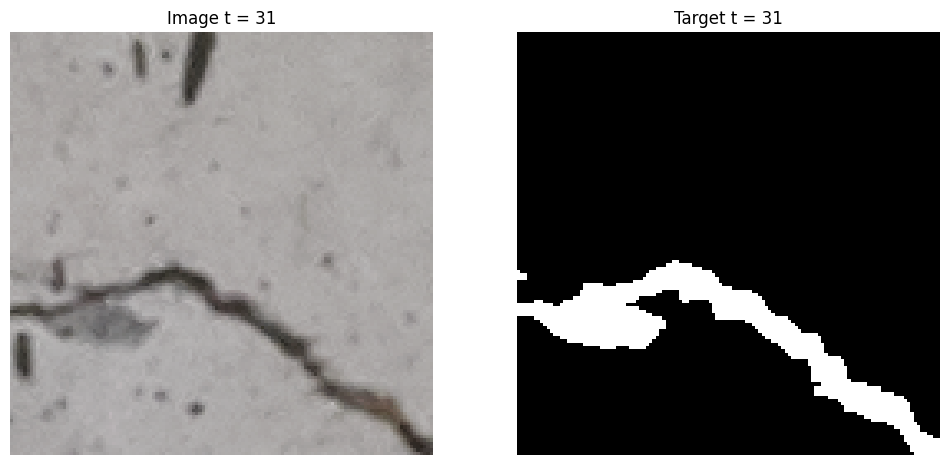

In [143]:
train_mt_dataset.visualize(350)


#### Experiment 3

In [144]:
trans_mono = transforms.Compose([
    RandomContrast(p = 0.5, contrast = (0.1,1.9)),
    RandomVerticalFlip(p=0.5),
    RandomHorizontalFlip(p=0.5),
    RandomBlur(p = 0.5, sigma_range = (0.5, 2.0)),
    RandomBrightness(p=0.5, brightness=(0.5, 1.7)),
    ToTensor()])

In [145]:
train_mono_exp3 = CrackDataset(mono_train_images, mono_train_targets, transform = trans_mono)
val_mono_exp3 = CrackDataset(mono_val_images, mono_val_targets)

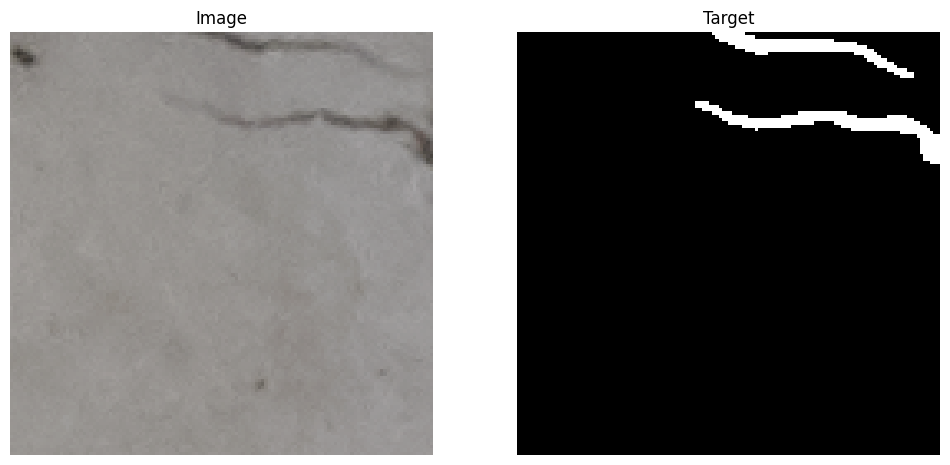

In [152]:
train_mono_exp3.visualize(20431)

#### Look for images with high pixel count for visualization later

In [33]:
test_sorted = test.loc[natsorted(test.index, key=lambda x: test.loc[x, 'path_image'].lower())]
test_sorted.reset_index(drop=True, inplace=True)
test_images = test_sorted["path_image"]
test_targets = test_sorted["path_target"]

In [34]:
top_10_crack_rows = test_sorted.nlargest(10, 'num_pixels')
top_10_crack_rows

path_image  \
377  ../../data_creation/data_pipeline/multi-tempor...   
189  ../../data_creation/data_pipeline/multi-tempor...   
178  ../../data_creation/data_pipeline/multi-tempor...   
63   ../../data_creation/data_pipeline/multi-tempor...   
141  ../../data_creation/data_pipeline/multi-tempor...   
103  ../../data_creation/data_pipeline/multi-tempor...   
380  ../../data_creation/data_pipeline/multi-tempor...   
341  ../../data_creation/data_pipeline/multi-tempor...   
364  ../../data_creation/data_pipeline/multi-tempor...   
351  ../../data_creation/data_pipeline/multi-tempor...   

                                           path_target  crack  num_pixels  \
377  ../../data_creation/data_pipeline/multi-tempor...      1       37644   
189  ../../data_creation/data_pipeline/multi-tempor...      1       37489   
178  ../../data_creation/data_pipeline/multi-tempor...      1       31379   
63   ../../data_creation/data_pipeline/multi-tempor...      1       30238   
141  ../../data_creation/data_pipeline/multi-tempor...      1       30119   
103  ../../data_creation/data_pipeline/multi-tempor...      1       30015   
380  ../../data_creation/data_pipeline/multi-tempor...      1       29932   
341  ../../data_creation/data_pipeline/multi-tempor...      1       26884   
364  ../../data_creation/data_pipeline/multi-tempor...      1       26745   
351  ../../data_creation/data_pipeline/multi-tempor...      1       24868   

     crack_pixel_bins  
377                18  
189                18  
178                18  
63                 18  
141                18  
103                18  
380                18  
341                18  
364                18  
351                18

#### Dataset and Dataloader

In [35]:
train_mt_dataset = MtCrackDataset(train_images, train_targets)
val_mt_dataset = MtCrackDataset(val_images, val_targets)

In [36]:
dataloader = DataLoader(train_mt_dataset, batch_size = 4, shuffle = True)
print(len(dataloader))
for batch in dataloader:
    target= batch[1]
    image = batch[0]
    print("\nImage")
    print(type(image))
    print(image.size())
    print(image.dtype)
    print("\nTarget")
    print(type(target))
    print(torch.unique(target))
    print(target.size())
    print(target.dtype)
    break

309

Image
<class 'torch.Tensor'>
torch.Size([4, 3, 128, 128, 32])
torch.float32

Target
<class 'torch.Tensor'>
tensor([0., 1.])
torch.Size([4, 1, 128, 128, 32])
torch.float32


## Swin UNETR

[Explanation of model from Monai](https://docs.monai.io/en/stable/networks.html)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))
roi = target_size
model = SwinUNETR(
    img_size=roi,
    in_channels=3,
    out_channels=1,
    feature_size=24,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
)

Device: cpu


In [6]:
total_params = sum(p.numel() for p in model.parameters())

# If you want only the trainable parameters (i.e., those with requires_grad=True)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 15704707
Trainable parameters: 15704707


In [38]:
trained_Swin = get_Swin_UNetR(train_mt_dataset, 
              val_mt_dataset,
              model,
              train = False, 
              n_classes = 1, 
              batch_size = 4, 
              learning_rate = 0.001, 
              num_epochs = 1, 
              sigmoid_threshold = 0.5, 
              verbose = True)

Using device: cpu


#### Visualization of Training Results

In [96]:
csv_file = '../UNet/Trained_Models/Official_Models/UNet5-55/model_nrepochs_75_sig_0-5_training_logs.csv'
log_wandb("Studienarbeit", "UNet_nrepochs_5_sig_0-5_BASELINE_1", csv_file)

# "TrainedModels/SwinUNetR4-76/model_nrepochs_96_sig_0-5_training_logs.csv"

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/saidharb/.netrc


#### Testing Results

In [17]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [33]:
model = SwinUNETR(
    img_size=target_size,
    in_channels=3,
    out_channels=1,
    feature_size=24,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
)
model_name = "model_nrepochs_96_sig_0-5.pth"
model_checkpoint = os.path.join("TrainedModels", "SwinUNetR1-96", model_name)
checkpoint = torch.load(model_checkpoint, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Loaded SwinUNetR model from {}.".format(model_checkpoint))

Loaded SwinUNetR model from TrainedModels/SwinUNetR1-96/model_nrepochs_96_sig_0-5.pth.


In [34]:
def evaluate_test_set(test_set, model, sigmoid_threshold = 0.5):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    testloader = DataLoader(test_set, batch_size = 4, shuffle = False)
    criterion = nn.BCEWithLogitsLoss() 
    score_test = SegmentationRunningScore(2)
    test_running_loss = 0.0
    total_TP = 0
    total_FP = 0
    total_FN = 0
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            print("{}/{}".format(i+1, len(testloader)), end='\r')
            images, targets = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            loss_test = criterion(outputs, targets)
            test_running_loss += loss_test.item()
           
            outputs = torch.sigmoid(outputs) > sigmoid_threshold
            outputs = outputs.int()

            TP, FP, FN = calculate_batch_metrics(outputs, targets)
            total_TP += TP
            total_FP += FP
            total_FN += FN

            targets = targets.cpu().numpy().astype(np.uint8)
            outputs = outputs.cpu().numpy().astype(np.uint8)

            score_test.update(targets, outputs)
            
            iou, _, dice, _ = score_test.get_scores()
            iou_no_crack = iou[0]
            iou_crack = iou[1]
            dice_no_crack = dice[0]
            dice_crack = dice[1]
            
    precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    
    print("Testing finished, avg. loss: {}, test_iou_1: {}, precision: {}, recall: {}, f1_score: {}".format(
        test_running_loss/len(testloader),
        iou_crack,
        precision,
        recall,
        f1_score),
        end = '\n',
        flush = True)
    

In [35]:
test_mt_dataset = MtCrackDataset(test_images, test_targets, transform = trans)

In [36]:
start_time = time.time()
evaluate_test_set(test_mt_dataset, model)
duration = time.time() - start_time
print(f"Duration: {round(duration/60)} minutes")

Using device: cpu
Testing finished, avg. loss: 0.020172586844097395, test_iou_1: 0.6496481050958949, precision: 0.8778758293188871, recall: 0.7141930658633152, f1_score: 0.7876202240818269
Duration: 20 minutes


In [30]:
model_unet = UNet(1)
model_checkpoint = os.path.join('../UNet/Trained_Models/Official_Models/UNet5-55/model_nrepochs_55_sig_0-5.pth')
checkpoint = torch.load(model_checkpoint, map_location=torch.device('cpu'))
model_unet.load_state_dict(checkpoint['model_state_dict'])
model_unet.eval()
print("Loaded UNet model from {}.".format(model_checkpoint))

Loaded UNet model from ../UNet/Trained_Models/Official_Models/UNet5-55/model_nrepochs_55_sig_0-5.pth.


In [31]:
trans_mono = transforms.Compose([
    RandomContrast(p = 0.5, contrast = (0.1,1.9)),
    RandomVerticalFlip(p=0.5),
    RandomHorizontalFlip(p=0.5),
    RandomBlur(p = 0.5, sigma_range = (0.5, 2.0)),
    RandomBrightness(p=0.5, brightness=(0.5, 1.7)),
    ToTensor()])

In [32]:
test_mono_dataset = CrackDataset(mono_test_images, mono_test_targets, transform = trans_mono)
start_time = time.time()
evaluate_test_set(test_mono_dataset, model_unet)
duration = time.time() - start_time
print(f"Duration: {round(duration/60)} minutes")

Using device: cpu
Testing finished, avg. loss: 0.2763811876943587, test_iou_1: 0.49379940721575627, precision: 0.8052504122355517, recall: 0.5607694368461946, f1_score: 0.6611321504486775
Duration: 13 minutes


Model| Avg. Loss            | Test IoU             | Precision            | Recall               | F1 Score   | Comment |
|--|----------------------|----------------------|----------------------|----------------------|------------------|--|
SwinUNetR_nrepochs_30_sig_0-5| 0.004273314164982786 | 0.8117194413112259   | 0.9064001866874644   | 0.8859849739962254   | 0.896076316014743    | First try|
UNet_nrepochs_30_sig_0-5| 0.005398999362160105 | 0.8346733046957855  | 0.92051103907552   | 0.899506696632235   | 0.9098876650785366    | First Try|
SwinUNetR_nrepochs_96_sig_0-5|0.007152492773106106| 0.8271813265138388 | 0.9193317679756571 | 0.8919188907891777  |    0.9054178854728722 | First correct Swin model|
UNet_nrepochs_48_sig_0-5|0.009399154237179212| 0.7660322439262027 | 0.8606405210367203 |  0.8745059684761253 |   0.8675178457933217  | First correct UNet model|


SwinUNetR_nrepochs_96_sig_0-5 is the baseline swin model

#### Visualize predictions

In [184]:
#visualize_prediction_model_mt(model, test_mt_dataset, 189)#377, 189, 

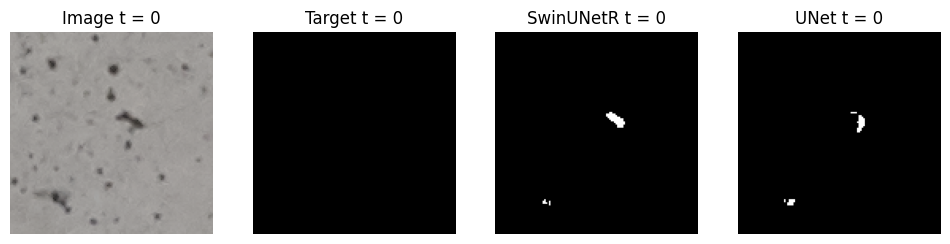

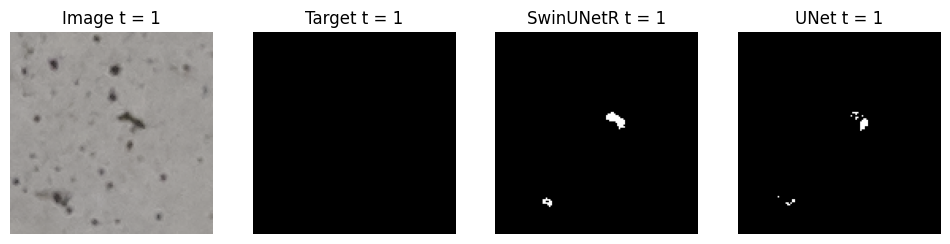

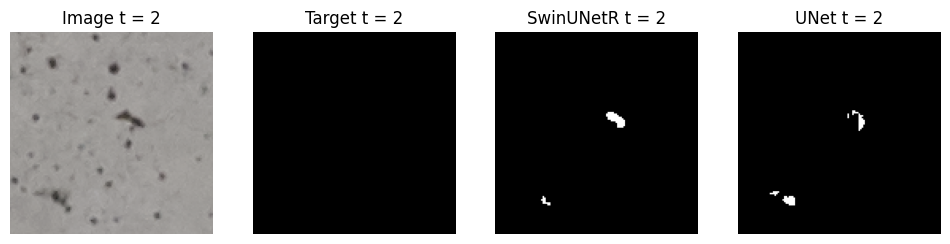

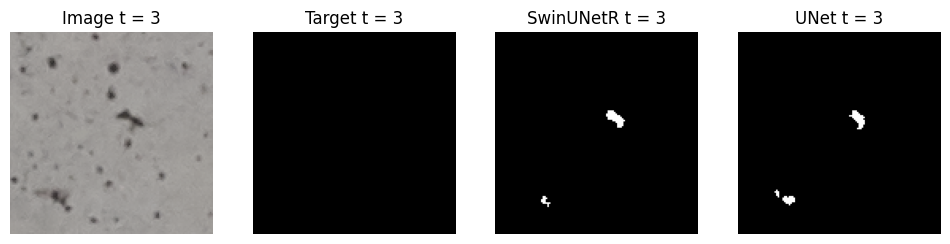

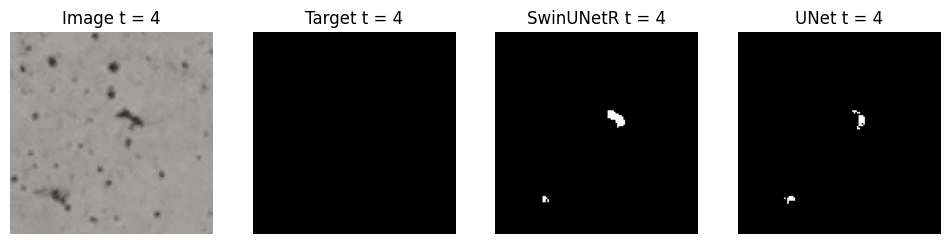

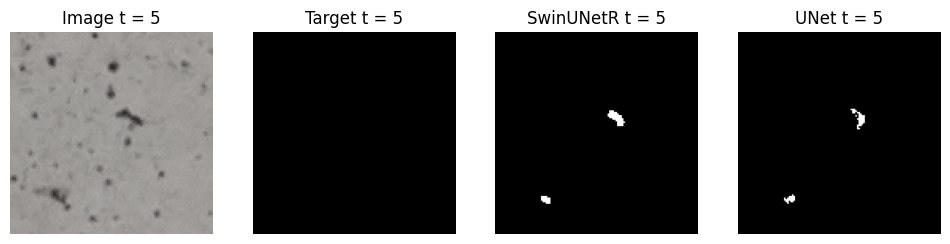

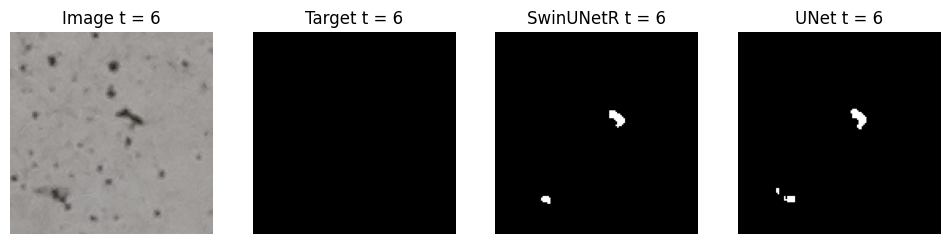

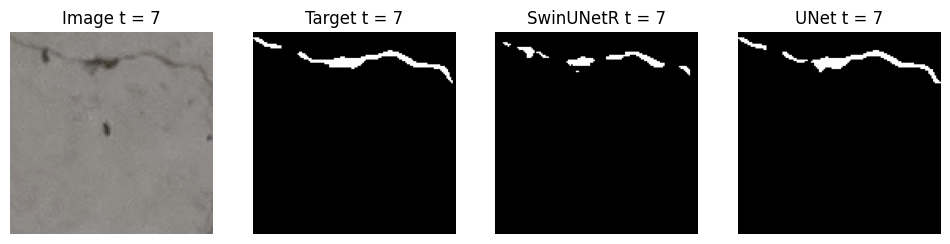

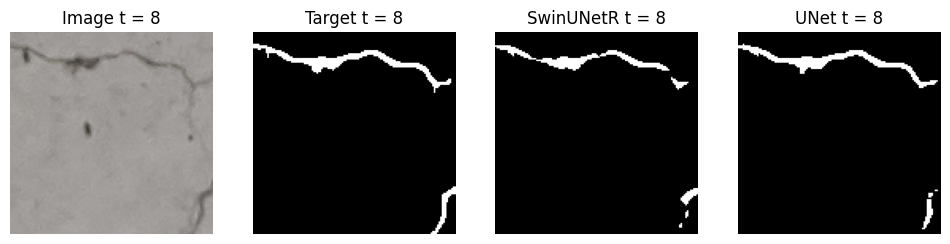

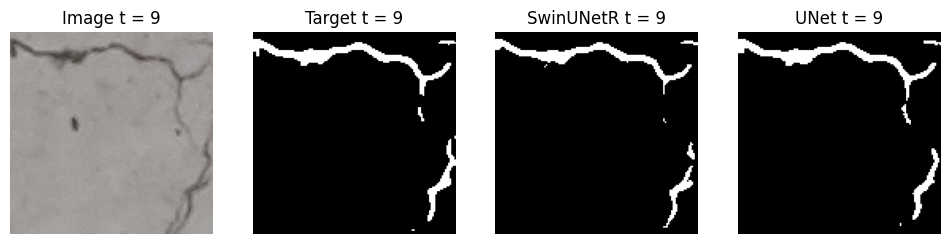

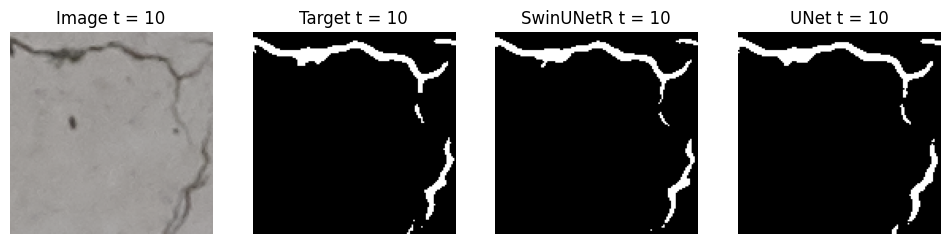

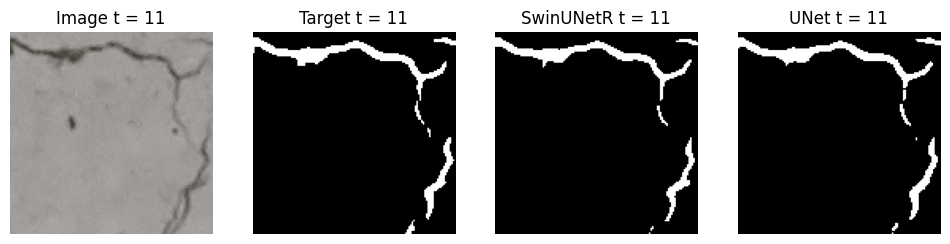

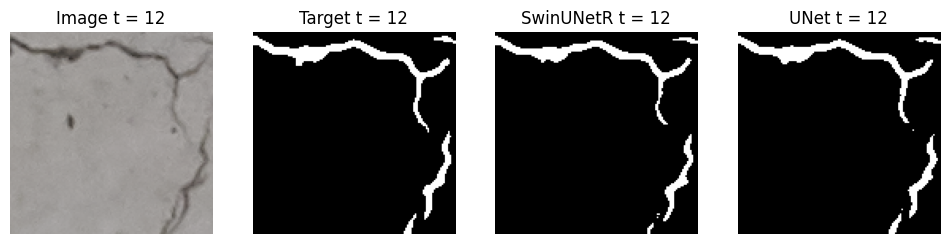

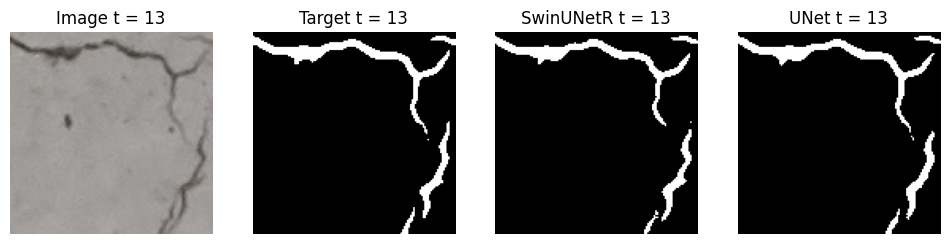

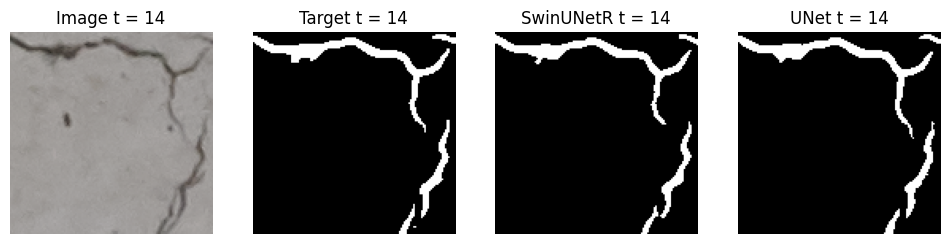

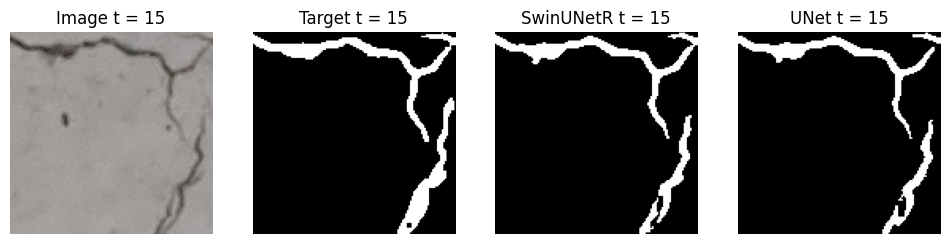

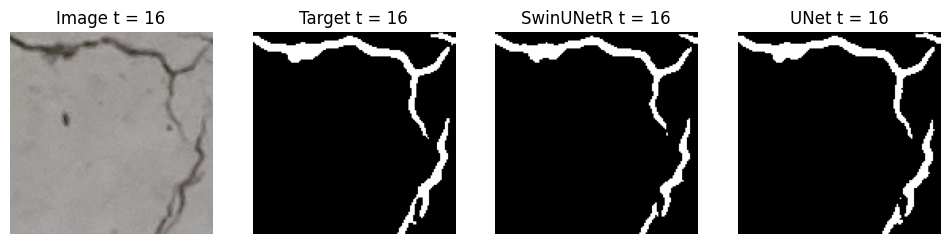

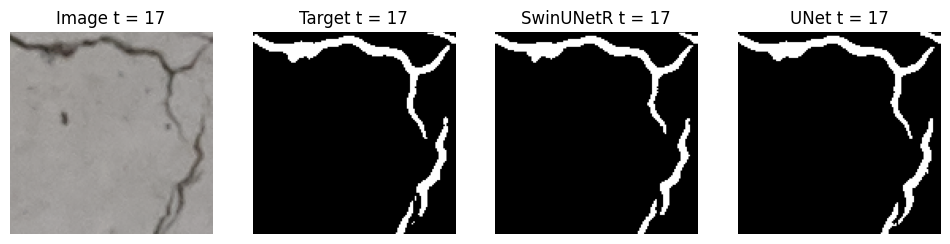

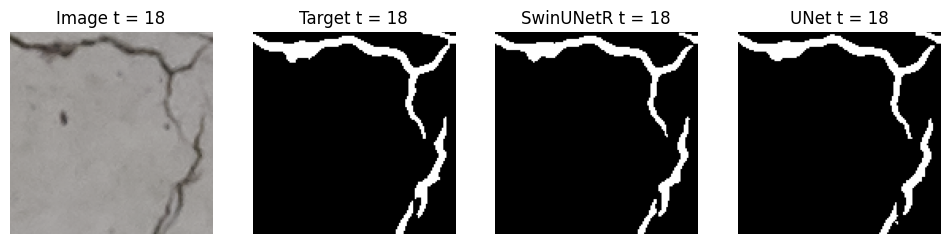

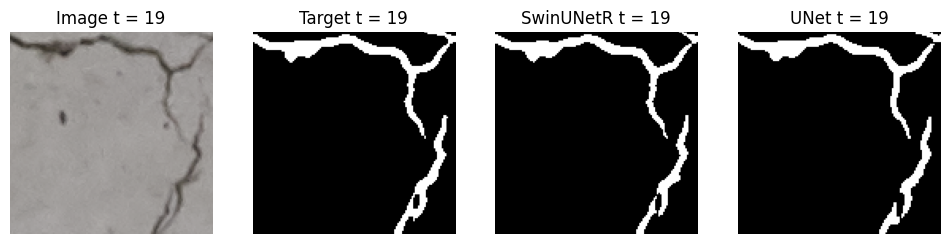

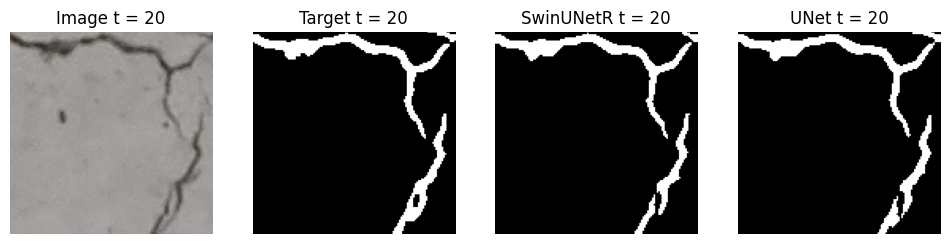

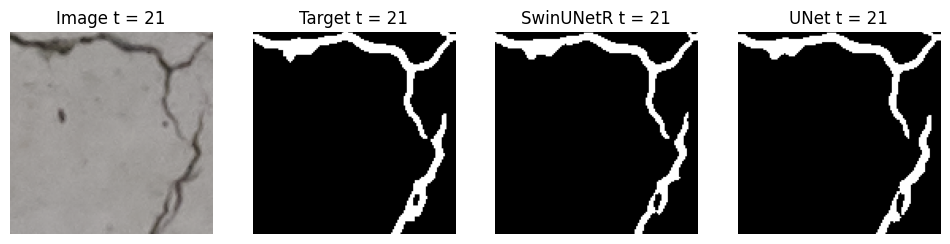

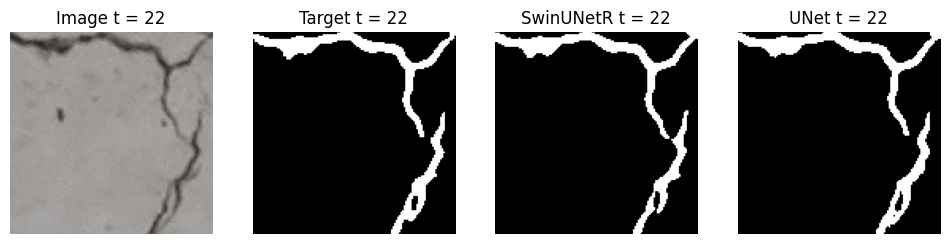

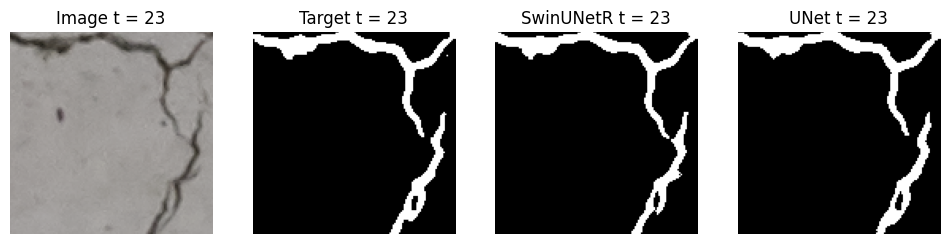

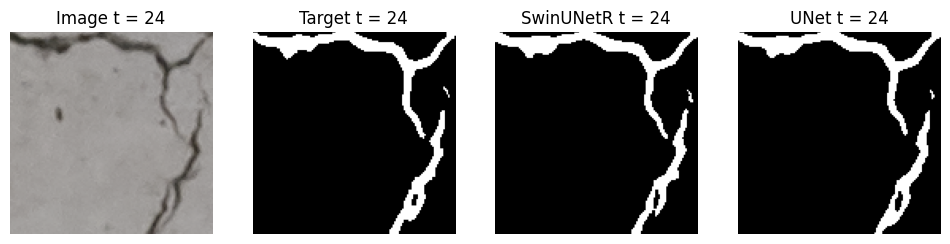

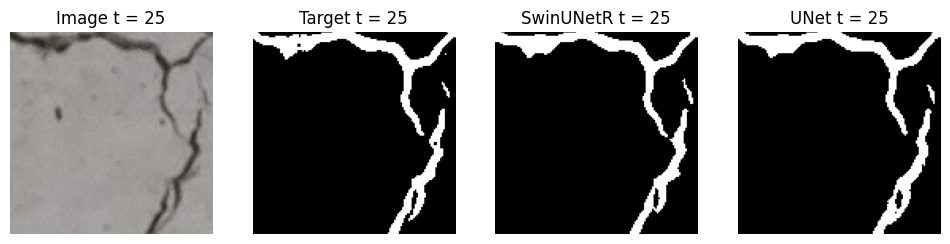

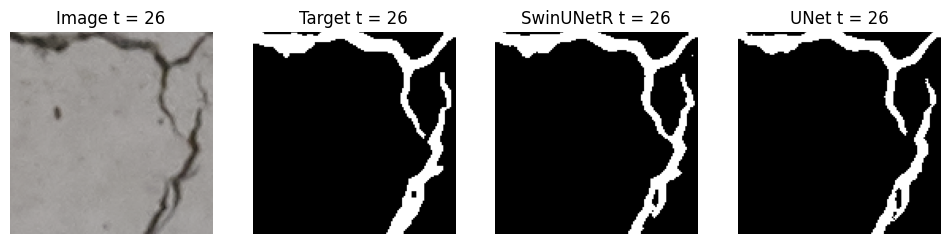

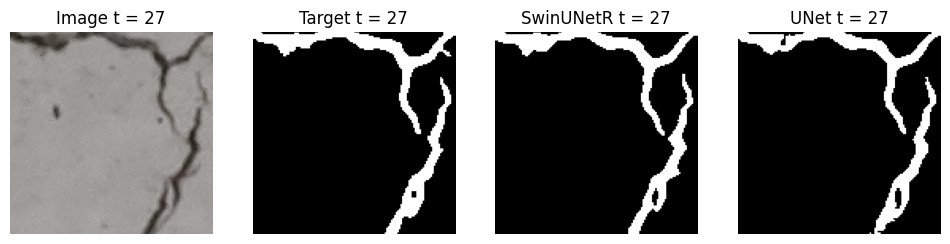

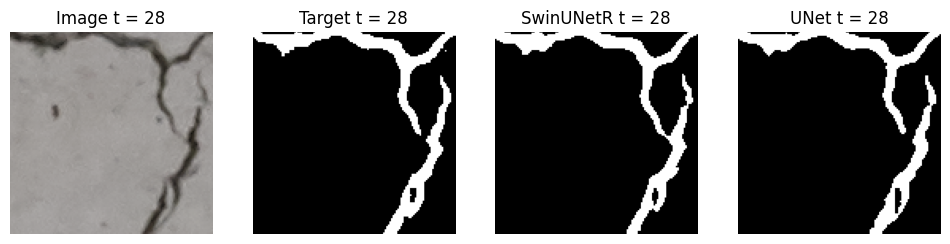

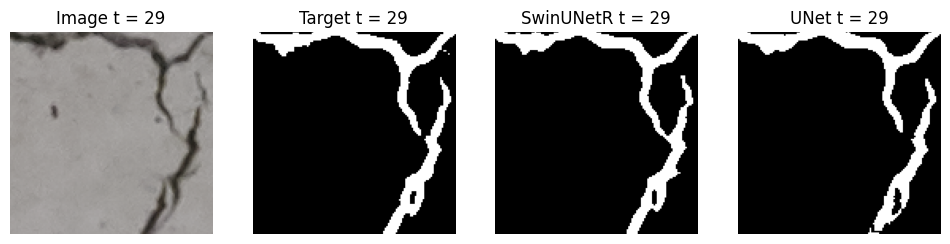

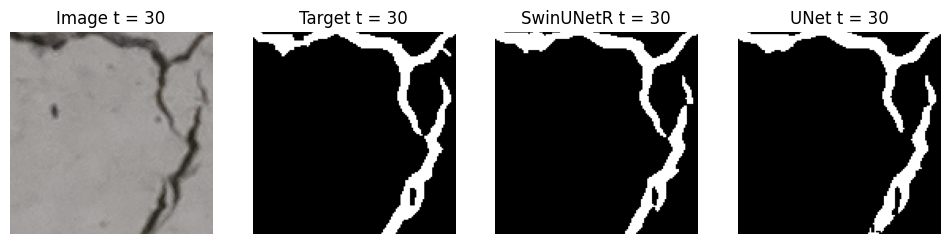

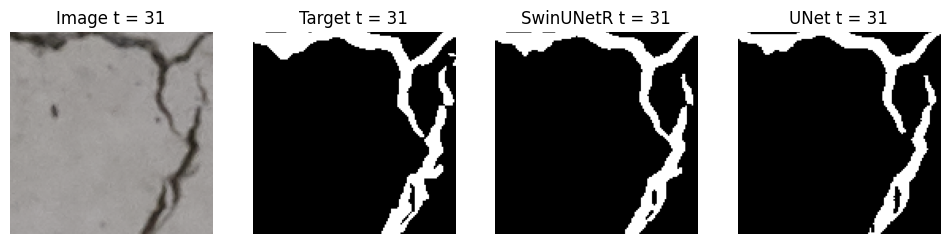

In [181]:
visualize_prediction_mt_2models(model, model_unet, test_mt_dataset,test_mono_dataset, 189, images_paths, targets_paths)#377, 189, 